In [132]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import pandas as pd
import itertools
import os
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
import keras.backend as K



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback

In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    'AccX',
    'AccY', 
    'AccZ', 
    'GyroX',
    'GyroY', 
    'GyroZ'
]

# Output classes to learn how to classify
LABELS = ['walking',
        'walking upstairs',
        'walking downstairs',
        'sitting',
        'standing',
        'laying']
RAW_DATA_PATH = "../G9_data/snippets/"
SUBJECT_LIST = [  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26]
seed = 7
np.random.seed(seed)

In [3]:
def load_data(Snippet_paths):
    X_signals = []
    y_signals = []
    usecols = INPUT_SIGNAL_TYPES + ['label']
    for snippet_path in Snippet_paths:
        df = pd.read_csv(snippet_path, usecols=usecols)
        y_signals.append(np.array(df['label'][0].reshape(1), dtype=np.int32))
        df = df[INPUT_SIGNAL_TYPES]
        c = df.values#.reshape(df.shape[0], df.shape[1])
        X_signals.append(c)
        
    return np.asarray(X_signals), np.asarray(y_signals)



def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = 6
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
def get_class_weights(y):
    from sklearn.utils import class_weight
    class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train.reshape(y_train.shape[0],))
                                               ,y_train.reshape(y_train.shape[0],))
    return  {cls: float(weight) for cls,weight in zip (np.unique(y_train.reshape(y_train.shape[0],)),class_weight)}



In [17]:
def plot_cm(cm, classes, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1]);
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

## Utility functions for training:


In [10]:
def LSTM_fit_predict(subject_no):
    
    Snippet_paths_train =[]
    Snippet_paths_test =[]
    for fol in LABELS:
        folder = RAW_DATA_PATH+'/'+fol+'/'  # folder = RAW_DATA_PATH+'/'+fol+'/'
        for root,dirs,files in os.walk(folder):
            for file_ in files:
                if file_.endswith(".csv"):
                    if int(file_.split("_")[0]) != subject_no:
                        Snippet_paths_train.append(folder+file_)
                    elif int(file_.split("_")[0]) == subject_no:
                        Snippet_paths_test.append(folder+file_)
                        
                        
    X_train,y_train = load_data(Snippet_paths_train)

    X_test,y_test = load_data(Snippet_paths_test)

    y_test = y_test - 1
    y_train = y_train - 1
    
    X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)
    X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)
    
    X_train_used = X_train_padded
    X_test_used = X_test_padded
    # Input Data 

    training_data_count = len(X_train_used)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test_used)  # 2947 testing series

    timesteps = len(X_train_used[0]) # 128 timesteps per series
    input_dim = len(X_train_used[0][0]) # 6 input parameters per timestep

    # LSTM Neural Network's internal structure

    n_hidden = 32 # Hidden layer num of features
    n_classes = 6 # Total classes (should go up, or should go down)


    # Training 

    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 300  # Loop 300 times on the dataset
    batch_size = 1500
    display_iter = 30000  # To show test set accuracy during training

    # Build model 
    model = Sequential()
    model.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
    model.add(LSTM(n_hidden))
    model.add(Dense(n_classes, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    history =model.fit(X_train_used,
              one_hot(y_train),
              batch_size=batch_size,
              validation_data=(X_test_used, one_hot(y_test)),
              epochs=100)


    # Evaluate
    predictions = model.predict(X_test_used).argmax(1)
    return predictions , y_test

In [156]:
def top_2_acc(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, 2)

In [ ]:


#LOO-Validation on each subject
y_test_all = []
y_pred_all = []
y_score_all = []

for subject_no in SUBJECT_LIST[:5]: # one combination of tested subjects
    print("--------------------- subject id: ",subject_no, ' ---------------------')
    Snippet_paths_train =[]
    Snippet_paths_test =[]
    for fol in LABELS:
        folder = RAW_DATA_PATH+'/'+fol+'/'  # folder = RAW_DATA_PATH+'/'+fol+'/'
        for root,dirs,files in os.walk(folder):
            for file_ in files:
                if file_.endswith(".csv"):
                    if int(file_.split("_")[0]) != subject_no:
                        Snippet_paths_train.append(folder+file_)
                    elif int(file_.split("_")[0]) == subject_no:
                        Snippet_paths_test.append(folder+file_)
                        
                        
    X_train,y_train = load_data(Snippet_paths_train)

    X_test,y_test = load_data(Snippet_paths_test)

    y_test = y_test - 1
    y_train = y_train - 1
    
    X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)
    X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)
    
    X_train_used = X_train_padded
    X_test_used = X_test_padded
    # Input Data 

    training_data_count = len(X_train_used)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test_used)  # 2947 testing series

    timesteps = len(X_train_used[0]) # 128 timesteps per series
    input_dim = len(X_train_used[0][0]) # 6 input parameters per timestep

    # LSTM Neural Network's internal structure

    n_hidden = 32 # Hidden layer num of features
    n_classes = 6 # Total classes (should go up, or should go down)


    # Training 

    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    batch_size = 1500

    # Build model 
    model = Sequential()
    model.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
    model.add(Dropout(0.5))
    model.add(LSTM(n_hidden))
    
    model.add(Dense(n_classes, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    history =model.fit(X_train_used,
                       one_hot(y_train),
                       batch_size=batch_size,
                       validation_data=(X_test_used, one_hot(y_test)),
                       epochs=50,
                       class_weight = get_class_weights(y_train))


    # Evaluate
    y_score = model.predict(X_test_used)
    y_score_all.extend(y_score)
    predictions = y_score.argmax(1)
    
    y_test_all.extend(list(y_test))
    y_pred_all.extend(list(predictions))
y_pred_all = np.array(y_pred_all, dtype=np.int32)
y_pred_all = y_pred_all.tolist()
y_test_all = [l[0] for l in y_test_all]

--------------------- subject id:  1  ---------------------
Train on 23951 samples, validate on 1077 samples
Epoch 1/50
23951/23951 [==============================] - 24s 983us/step - loss: 1.6002 - acc: 0.3988 - val_loss: 1.3666 - val_acc: 0.2544
Epoch 2/50
23951/23951 [==============================] - 14s 587us/step - loss: 1.4248 - acc: 0.4485 - val_loss: 1.2932 - val_acc: 0.3370
Epoch 3/50
23951/23951 [==============================] - 14s 577us/step - loss: 1.3264 - acc: 0.5261 - val_loss: 1.2449 - val_acc: 0.4373
Epoch 4/50
23951/23951 [==============================] - 15s 611us/step - loss: 1.2415 - acc: 0.5648 - val_loss: 1.2300 - val_acc: 0.4475
Epoch 5/50
23951/23951 [==============================] - 14s 569us/step - loss: 1.1681 - acc: 0.5838 - val_loss: 1.1973 - val_acc: 0.4745
Epoch 6/50
23951/23951 [==============================] - 14s 573us/step - loss: 1.1117 - acc: 0.5980 - val_loss: 1.1528 - val_acc: 0.5070
Epoch 7/50
23951/23951 [==============================] -

## And finally, the multi-class confusion matrix and metrics!

In [179]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 128, 32)           4992      
_________________________________________________________________
dropout_32 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 198       
Total params: 13,510
Trainable params: 13,510
Non-trainable params: 0
_________________________________________________________________



Precision: 70.2903692377%
Recall: 69.245142003%
f1_score: 68.5706100045%
Normalized confusion matrix


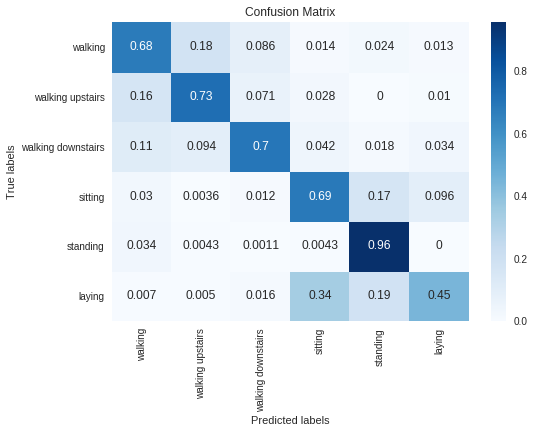

In [180]:
# Results

# predictions = one_hot_predictions.argmax(1)

predictions = y_pred_all
y_test = y_test_all
# print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

cm =  confusion_matrix(y_test, predictions)
plot_cm(cm, LABELS)

In [181]:
from sklearn.metrics import auc
import numpy as np
from sklearn import metrics

In [182]:
y_score = y_score_all
y_score = np.array(y_score)
y_test = one_hot(np.array(y_test_all))

In [183]:
best_n = np.argsort(y_score, axis=0)

In [184]:
best_n

array([[5151, 3746, 2571, 2212, 2409, 4306],
       [ 932, 3583, 2519, 1221, 3302, 1091],
       [4225, 3686, 2805, 2395, 2362, 1111],
       ...,
       [4289, 4487, 2848, 3858, 4037, 4292],
       [3293, 4464, 2280,  335, 4019, 4142],
       [3859, 4492, 4199,  646, 4021, 4245]])

In [1]:
def auc_roc_plot(y_test, y_score, classes  = 'all'):
    from sklearn.metrics import roc_curve, auc
    if classes is None:
        classes = list(range(y_test.shape[1]))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    

In [186]:
y_test.shape, y_score.shape

((5352, 6), (5352, 6))

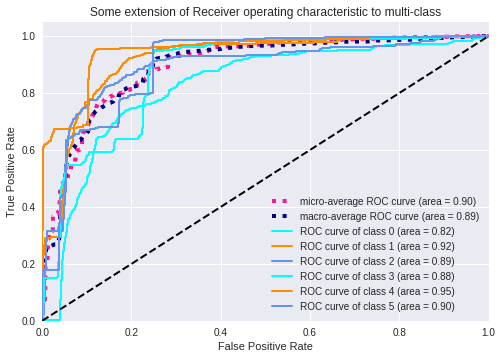

In [187]:
auc_roc_plot(y_test, y_score,classes=None)

In [191]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(X_test_used[1,:,:])

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [192]:
pca_score = pca.explained_variance_ratio_
V = pca.components_

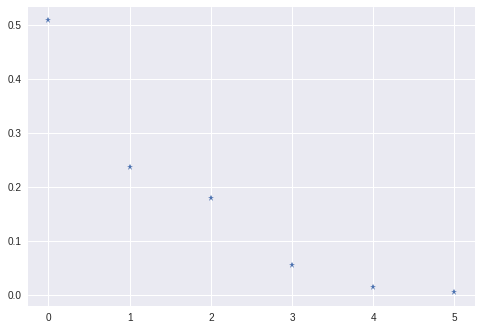

In [193]:
plt.plot(pca_score, '*')
plt.show()

In [96]:
X_test_used[1,:,:].shape

(128, 6)

In [120]:
np.concatenate([model.predict(X_test_used), model.predict(X_test_used)]).shape

(1940, 6)

In [122]:
b = model.predict(X_test_used)

In [126]:
a = []

In [128]:
a.extend(b)

In [175]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from functools import partial
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K
from itertools import product

# Custom loss function with costs

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

w_array = np.ones((6,6))
w_array[3, 5] = 1.2
w_array[5, 3] = 10

ncce = partial(w_categorical_crossentropy, weights=w_array)

array([[ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1.2],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ],
       [ 1. ,  1. ,  1. , 10. ,  1. ,  1. ]])